In [1]:
# =============================================
# STEP 1: Install required libraries
# =============================================
!pip install pandas statsmodels seaborn matplotlib openpyxl
!pip install pingouin

In [2]:
# =============================================
# STEP 2: Import libraries
# =============================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pingouin as pg

In [ ]:
# --- STEP 1: Upload the Excel file ---
from google.colab import files
uploaded = files.upload() #adult_combined.xlsx

In [3]:
# =============================================
# STEP 3: Read Excel file
# =============================================
df = pd.read_excel("adult_combined.xlsx")
print("Data loaded successfully!")
print(df.head())


Data loaded successfully!
   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0 

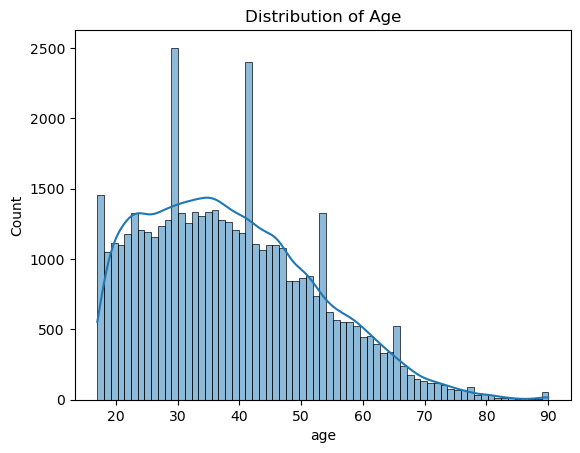

In [4]:
# =============================================
# STEP 4: Quick EDA / Visualization
# =============================================
# Histogram of dependent variable
sns.histplot(df['age'], kde=True)
plt.title("Distribution of Age")
plt.show()

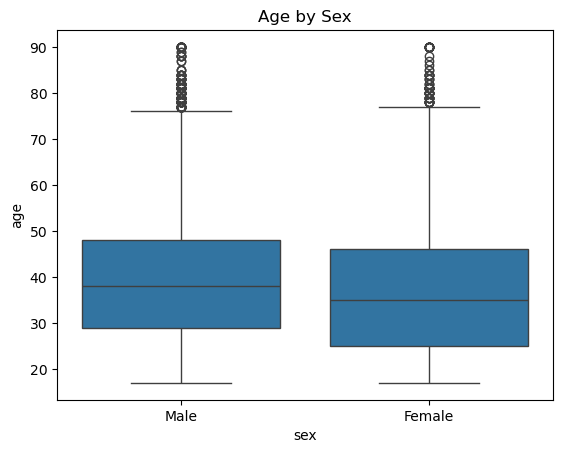

In [5]:
# Boxplot of dependent variable vs categorical independent variable
sns.boxplot(x='sex', y='age', data=df)
plt.title("Age by Sex")
plt.show()

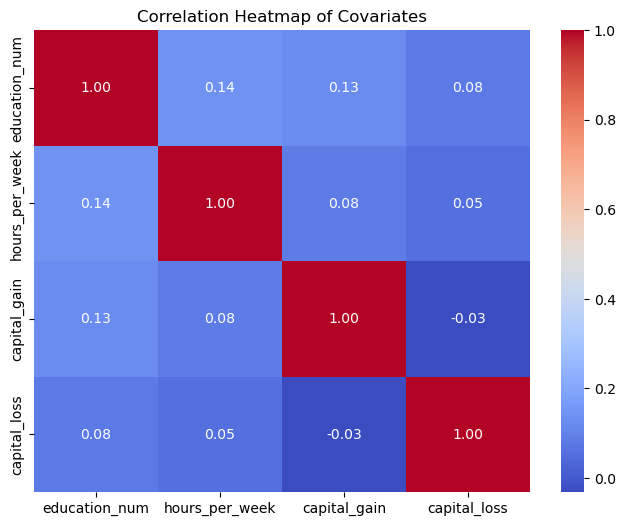

In [6]:
# check for multicollinearity — covariates that are highly (r > 0.8) correlated
# List of covariates
covariates = ['education_num','hours_per_week','capital_gain','capital_loss']

# Compute correlation matrix
corr_matrix = df[covariates].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Covariates")
plt.show()


In [7]:
# =============================================
# STEP 5: Preprocessing
# =============================================
# Drop rows with missing values
df.dropna(inplace=True)

# Optional: encode categorical variables if needed
# Here sex is the independent variable
df['sex'] = df['sex'].astype('category')


In [8]:
# =============================================
# STEP 7: Fit ANCOVA model
# =============================================
# Dependent variable: age
# Independent variable: sex
# Covariates: education_num, hours_per_week, capital_gain, capital_loss

model = ols('age ~ C(sex) + education_num + hours_per_week + capital_gain + capital_loss', data=df).fit()

# ANOVA table
#we use anova for ancova because ancova is using covariates
anova_results = anova_lm(model, typ=2)
print("\nANCOVA Results:")
print(anova_results)


ANCOVA Results:
                      sum_sq       df           F        PR(>F)
C(sex)          4.503368e+04      1.0  244.016769  7.110846e-55
education_num   1.016821e+03      1.0    5.509684  1.891544e-02
hours_per_week  1.709026e+04      1.0   92.604224  6.679655e-22
capital_gain    4.452752e+04      1.0  241.274088  2.798756e-54
capital_loss    2.506980e+04      1.0  135.841704  2.377838e-31
Residual        9.012762e+06  48836.0         NaN           NaN


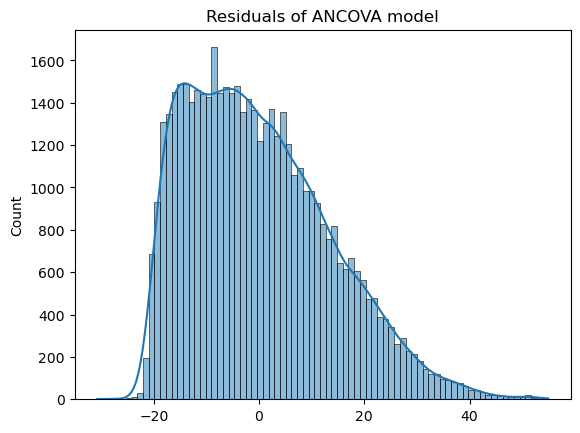

In [9]:

# Check residuals
residuals = model.resid
sns.histplot(residuals, kde=True)
plt.title("Residuals of ANCOVA model")
plt.show()


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
Female   Male   2.5664   0.0 2.3091 2.8237   True
-------------------------------------------------


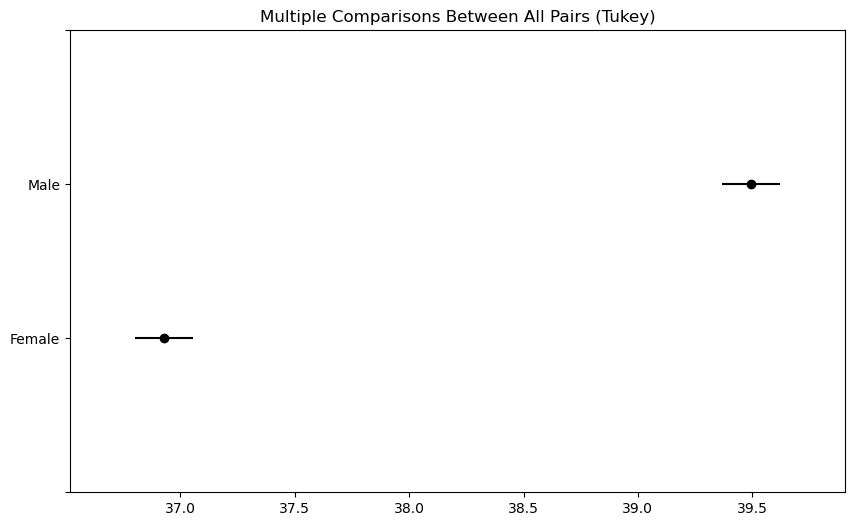

In [10]:
# =============================================
# STEP 8: Post-hoc / Tukey HSD (if needed)
# =============================================
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD requires categorical DV vs groups;
# we can do Tukey for covariates grouped by sex if desired
# For illustration, let's check income (categorical) vs sex
# But if DV is continuous (age), Tukey is not strictly needed unless multiple groups

# Example: Tukey HSD for income vs sex
df['income'] = df['income'].astype('category')
tukey = pairwise_tukeyhsd(endog=df['age'], groups=df['sex'], alpha=0.05)
print(tukey)
tukey.plot_simultaneous()
plt.show()
